For my project, I am using climate change precipitation changes (as a proxy for flooding/hurricanes) to predict future housing/commercial real estate prices in the continental U.S. While climate change is already established, humans have done a poor job so far adapting to the new changes. The future of our economy is dependent on climate change and its effects on the United States geography, including from hurricanes, flooding, and other extreme weather events and it would benefit businesses greatly if they were aware of the places best suited to build businesses/headquarters, where new hubs are likely to be centered in the future and where forward-thinking businesses will begin focusing on now. To do this, I plan to use either Random Forests or Matrix Factorization to distinguish the role of precipitation in determining the cost of an area and use that along with expected future temperature to predict housing prices in the future. By placing these expected costs on an average precipitation map of the US (by season), companies can gain a better understanding of where the future of their business is. 

In [226]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sqlite3
from sqlite3 import Error

In [237]:
#Load SQL
def create_connection(path):

    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

create_connection("C:/Users/Aroob Abdelhamid/earth-analytics/housing.sqlite") #create a new database first before running this

Connection to SQLite DB successful


In [158]:
#load city_info first to get station names from ID, and get 'Lon' and 'Lat' and append the loc info to loaded csv with the same filename as ID in city_info
def load_temp_precip_files():
    path = r'C:\Users\Aroob Abdelhamid\earth-analytics\DataIncubator\CMU_TempPrecip_Meas'
    #load city_info first
    city_info = pd.read_csv(path+"\city_info.csv")
    
    all_files = []
    
    #rest of the files   
    T_Pr_files = glob.glob(path + "/US*.csv")#"/US*.csv")
    for filename in T_Pr_files:
        f = pd.read_csv(filename, header=0)
        nm_ext = os.path.basename(filename); nm = os.path.splitext(nm_ext) #get just the filename to search in city_info
        
        #get city_info_data into precip data
        ID_ind = city_info.index[city_info['ID'] == nm[0]]
        Lat = city_info['Lat'][ID_ind[0]]; Lon = city_info['Lon'][ID_ind[0]]
        f['Lat'] = Lat; f['Lon'] = Lon         
        f['year'] = f['Date'].str[0:4].astype(float); f['month']=f['Date'].str[5:7].astype(float); f['day']=f['Date'].str[8:10].astype(float);
        f['year2'] = f['Date'].str[0:4].astype(float); f['month2']=f['Date'].str[5:7].astype(float);
        f_avg = f.groupby(['year2','month2'], sort=False).mean() 
        
#       put it all together
        all_files.append(f_avg)
    
    T_Pr = pd.concat(all_files, axis=0, ignore_index=True)
    return T_Pr

#load_temp_precip_files()
T_Pr = load_temp_precip_files()

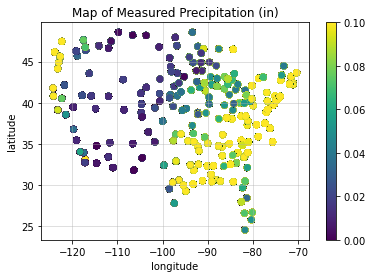

In [236]:
plt.scatter(T_Pr['Lon'], T_Pr['Lat'], vmin=0, vmax=0.1 , c= T_Pr['prcp'])
plt.xlabel('longitude')
plt.grid(axis='both', alpha=0.5)
plt.colorbar()
plt.ylabel('latitude')
plt.title('Map of Measured Precipitation (in)')

As you can see, the precipitation is highest at the coasts and specifically in the SE. As climate change makes hurricanes more intense and changes precipitation patterns, I expect the areas in yellow to be some of the hardest hit, and that is where I expect the housing market to show the most changes. We can inspect that by comparing the housing market prices to these values and seeing if they changed over time.

In [203]:
def load_house_prices_data():
    #load files
    path = r'C:\Users\Aroob Abdelhamid\earth-analytics\DataIncubator'
    house = pd.read_csv(path+"/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv")

    #add zipcode lat/lon
    zipcode = pd.read_csv(path+"/us-zip-code-latitude-and-longitude.csv")
    for iloc in range(zipcode.shape[0]):
        if int(zipcode['Zip'][iloc]) in house['RegionName']:
            currzip = zipcode['Zip'][iloc]
            zip_ind= house.index.values[house['RegionName'] == int(currzip)]
            print(zip_ind, currzip, iloc)
            break

    return(zipcode, house)   

(zipcode,house) = load_house_prices_data()

[] 29079 3


At this stage, I have loaded the precipitation data, and I have loaded the housing data. I plan to use latitude and longitude to connect the housing data to the precipitation data (by city), so I have connected the precipitation data to latitudes and longitudes, as well as averaged the precipitation data by year and month, as the housing data is monthly. 
Due to time constraints, I have been unable to finish connecting the two different datasets.